In [1]:
from tensorflow.keras import layers
import tensorflow as tf

import os
import numpy as np
from glob import glob
import cv2
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict
from PIL import Image

# For data preprocessing
from tensorflow import image as tf_image
from tensorflow import data as tf_data
from tensorflow import io as tf_io

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
IMG_HEIGHT = 544
IMG_WIDTH = 1024


IMG_SIZE = 224

NUM_EPOCHS = 20
BATCH_SIZE = 16
BUFFER_SIZE = 1000
NUM_MASK_CHANNELS = 9


LEARNING_RATE = 1e-5

DATA_DIR = "./yamaha/"

In [9]:
train_images = sorted(glob(os.path.join(DATA_DIR, "images/training/YCOR*")))
train_masks = sorted(glob(os.path.join(DATA_DIR, "annotations/training/YCOR*")))
val_images = sorted(glob(os.path.join(DATA_DIR, "images/validation/YCOR*")))
val_masks = sorted(glob(os.path.join(DATA_DIR, "annotations/validation/YCOR*")))

In [10]:
print(len(train_images))
print(len(val_images))
print(len(train_masks))
print(len(val_masks))

931
145
931
145


In [7]:
# Another dataset : DeepScene Forest

In [11]:
def display_example_pair(image: np.ndarray, mask: np.ndarray) -> None:
    """ Visualizes input image and segmentation map. Used for visualizations.

    Args:
        image: (np.ndarray) the rgb image
        mask: (np.ndarray) the mask of the input image

    Returns:
        None
    """
    _, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Original Image')
    ax[1].imshow(mask)
    ax[1].axis('off')
    ax[1].set_title('Mask')

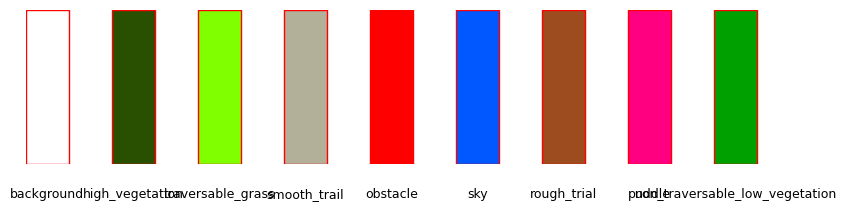

In [12]:
LABEL_TO_COLOR = OrderedDict({
"background": [255, 255, 255],
"high_vegetation": [40, 80, 0],
"traversable_grass": [128, 255, 0],
"smooth_trail": [178, 176, 153],
"obstacle": [255, 0, 0],
"sky": [1, 88, 255],
"rough_trial": [156, 76, 30],
"puddle": [255, 0, 128],
"non_traversable_low_vegetation": [0, 160, 0]
})

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Create mini rectangles for each color
for i, (label, color) in enumerate(LABEL_TO_COLOR.items()):
    i = i * 2
    # Normalize RGB colors
    normalized_color = [c / 255.0 for c in color]
    # Create a patch
    rect = patches.Rectangle((i, 0), 1, 1, linewidth=1, edgecolor='r', facecolor=normalized_color)
    # Add the patch to the Axes
    ax.add_patch(rect)
    # Add text label
    plt.text(i + 0.5, -0.2, label, ha='center', va='center', fontsize=9)

# Set limits and turn off axes
ax.set_xlim(0, len(LABEL_TO_COLOR) * 2)
ax.set_ylim(0, 1)
ax.axis('off')

plt.show()

In [13]:
PALETTE = list(LABEL_TO_COLOR.values())
CLASSES = list(LABEL_TO_COLOR.keys())

palette = np.array(PALETTE, dtype=np.uint8)

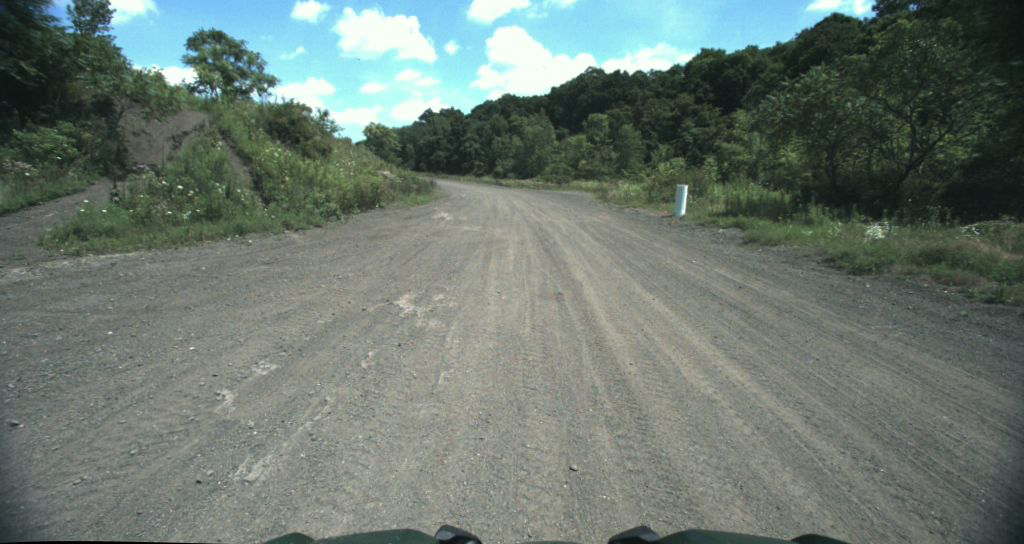

In [9]:
number = 54

example_image = Image.open(train_images[number])
example_image

In [11]:
example_mask = Image.open(train_masks[number])
example_mask = np.array(example_mask)

rgb_mask = palette[example_mask]

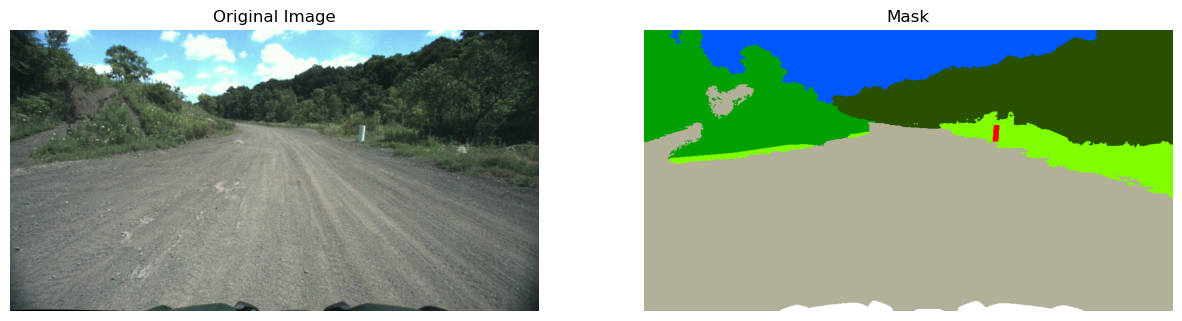

In [12]:


image_display = np.array(example_image)
mask_display = np.array(rgb_mask)

display_example_pair(image_display, mask_display)

In [14]:
def read_image(image_path, mask=False):
    image = tf_io.read_file(image_path)
    if mask:
        image = tf_image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf_image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
        image = tf.cast(image, tf.int32)

        valid_values_mask = tf.logical_and(image >= 0, image <= 8)
        assert_condition = tf.debugging.assert_equal(tf.reduce_all(valid_values_mask), True, message="Mask values out of range 0 to 8")
    else:
        image = tf_image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf_image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask

# def read_image(image_path, mask = False):
#     if mask:
#         image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        
#         image = image.reshape(-1, 3)
#         new_image = np.empty_like(image[:, 0])
#         new_image.fill(255)
        
#         for idx, c in enumerate(PALETTE):
#             matching = np.all(image == c, axis = 1)
#             new_image[matching] = idx

#         if 255 in np.unique(new_image):
#             print(image_path)
#         return new_image
        
    
#     else:    
#         image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
#         image = np.array(image)
#         return image

#########################################

# image_list = [None] * len(train_images)
# mask_list = [None] * len(train_masks)

# for idx, val in enumerate(train_images):
#     image_list[idx] = read_image(val)

# for idx, val in enumerate(train_masks):
#     mask_list[idx] = read_image(val, True)

# train_dataset = data_generator(image_list, mask_list)

############################################

# image_list = [None] * len(val_images)
# mask_list = [None] * len(val_masks)

# for idx, val in enumerate(val_images):
#     image_list[idx] = read_image(val)

# for idx, val in enumerate(val_masks):
#     mask_list[idx] = read_image(val, True)

# val_dataset = data_generator(image_list, mask_list)

###########################################3


def data_generator(image_list, mask_list):
    dataset = tf_data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf_data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder= True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)


print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 224, 224, 1), dtype=tf.int32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(16, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 224, 224, 1), dtype=tf.int32, name=None))>


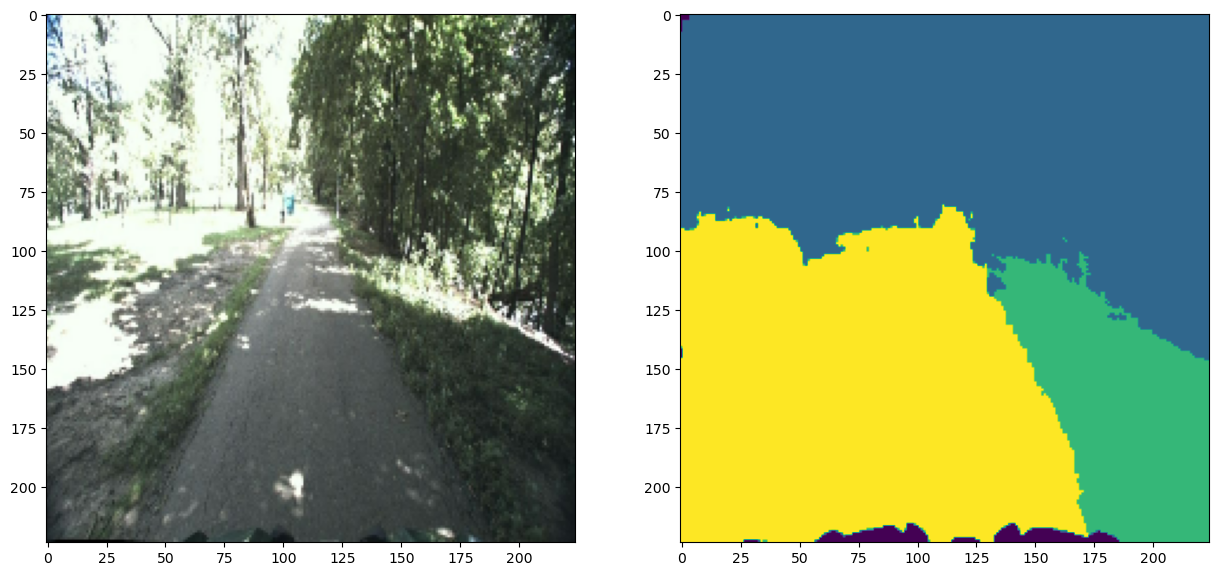

In [9]:
for i, j in train_dataset.take(1):
    _, ax = plt.subplots(1, 2, figsize=(15, 15))
    ax[0].imshow(i[0].numpy().astype("uint8"))
    ax[1].imshow(j[0].numpy().astype("uint8"))

In [15]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [16]:
model_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
preprocessed = tf.keras.applications.mobilenet_v3.preprocess_input(model_input)

In [17]:
mobileNetv3 = tf.keras.applications.MobileNetV3Small(weights="imagenet", include_top=False, input_tensor=preprocessed)
mobileNetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

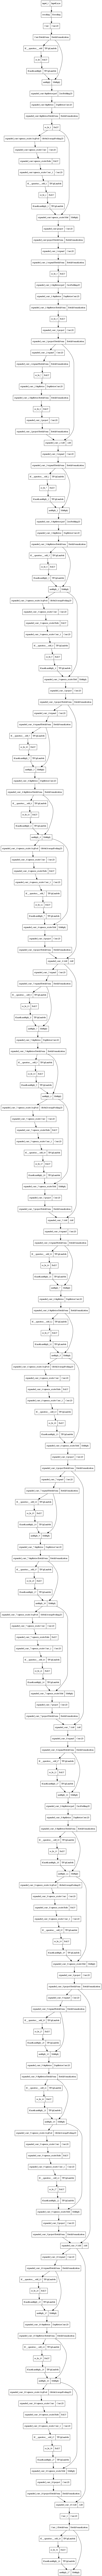

In [13]:
tf.keras.utils.plot_model(mobileNetv3)

In [35]:
########################################## RESNET
model_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
preprocessed = tf.keras.applications.resnet50.preprocess_input(model_input)

In [36]:
###################################### RESNET
resnet50_ = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=preprocessed)
resnet50_.summary()

# conv4_block6_2_relu : 32, 32, 256

# conv2_block3_2_relu : 64, 64, 128

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 512, 512, 3)  0          ['input_4[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.nn.bias_add_1 (TFOpLambda)  (None, 512, 512, 3)  0           ['tf.__operators__.getitem_1[0][0
                                                                 ]']                       

In [18]:
def DeeplabV3Plus(image_size, num_classes):
    x = mobileNetv3.get_layer("multiply_17").output
    x = DilatedSpatialPyramidPooling(x)
    
    # resnet50 = tf.keras.applications.ResNet50(
    #     weights="imagenet", include_top=False, input_tensor=preprocessed
    # )
    # x = resnet50.get_layer("conv4_block6_2_relu").output
    # x = DilatedSpatialPyramidPooling(x)

    print(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    print(input_a)
    # input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = mobileNetv3.get_layer("re_lu_3").output
    print(input_b)
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)
    print(input_b)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    # model_output = layers.Reshape((-1, 1))(model_output)
    return tf.keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMG_SIZE, num_classes=9)
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 256), dtype=tf.float32, name=None), name='tf.nn.relu_5/Relu:0', description="created by layer 'tf.nn.relu_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 256), dtype=tf.float32, name=None), name='up_sampling2d_1/resize/ResizeBilinear:0', description="created by layer 'up_sampling2d_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 72), dtype=tf.float32, name=None), name='re_lu_3/Relu:0', description="created by layer 're_lu_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 56, 56, 48), dtype=tf.float32, name=None), name='tf.nn.relu_6/Relu:0', description="created by layer 'tf.nn.relu_6'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                   

In [ ]:
# 32, 32, 256
# 128, 128, 256
# 128, 128, 64
# 128, 128, 48

In [19]:
initial_learning_rate = 1e-5
final_learning_rate = 1e-6
epochs = 20
epoch_steps = 1000  # Assuming an example number of steps per epoch

# Calculate the total number of steps for the decay
total_steps = epochs * epoch_steps

# Use exponential decay to reach the final_learning_rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=total_steps,
    decay_rate=final_learning_rate / initial_learning_rate,
    staircase=False  # Smooth decay
)

# Display an example of the learning rate for the first few steps
print("Learning rate at step 0: {:.8f}".format(lr_schedule(0).numpy()))
print("Learning rate at step {}: {:.8f}".format(total_steps, lr_schedule(total_steps).numpy()))

# Return the decay rate calculated based on the final and initial learning rate, and total steps
decay_rate = final_learning_rate / initial_learning_rate

lr_schedule, decay_rate


Learning rate at step 0: 0.00001000
Learning rate at step 20000: 0.00000100


(<keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay at 0x24f1c007490>,
 0.09999999999999999)

Epoch 1/20
58/58 [==============================] - 19s 170ms/step - loss: 2.1256 - accuracy: 0.2258 - val_loss: 1.9517 - val_accuracy: 0.3107
Epoch 2/20
58/58 [==============================] - 9s 158ms/step - loss: 1.6248 - accuracy: 0.4553 - val_loss: 1.6856 - val_accuracy: 0.4584
Epoch 3/20
58/58 [==============================] - 9s 158ms/step - loss: 1.3377 - accuracy: 0.5659 - val_loss: 1.4890 - val_accuracy: 0.5314
Epoch 4/20
58/58 [==============================] - 9s 161ms/step - loss: 1.1763 - accuracy: 0.6153 - val_loss: 1.3517 - val_accuracy: 0.5740
Epoch 5/20
58/58 [==============================] - 9s 162ms/step - loss: 1.0755 - accuracy: 0.6433 - val_loss: 1.2507 - val_accuracy: 0.6038
Epoch 6/20
58/58 [==============================] - 9s 161ms/step - loss: 1.0043 - accuracy: 0.6636 - val_loss: 1.1755 - val_accuracy: 0.6229
Epoch 7/20
58/58 [==============================] - 9s 158ms/step - loss: 0.9498 - accuracy: 0.6802 - val_loss: 1.1196 - val_accuracy: 0.6355
Epoch

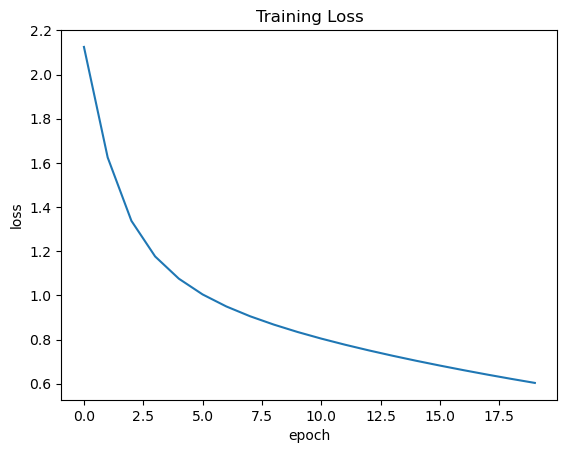

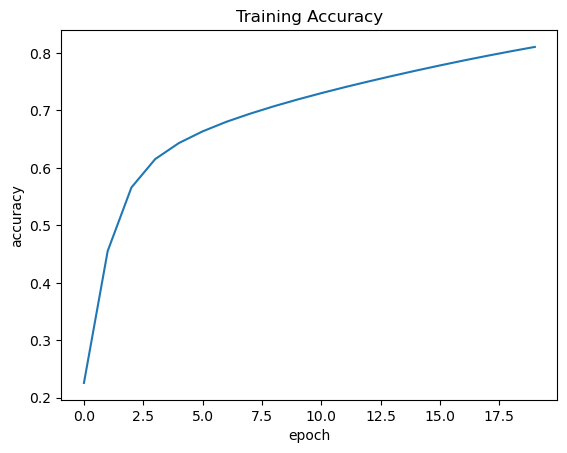

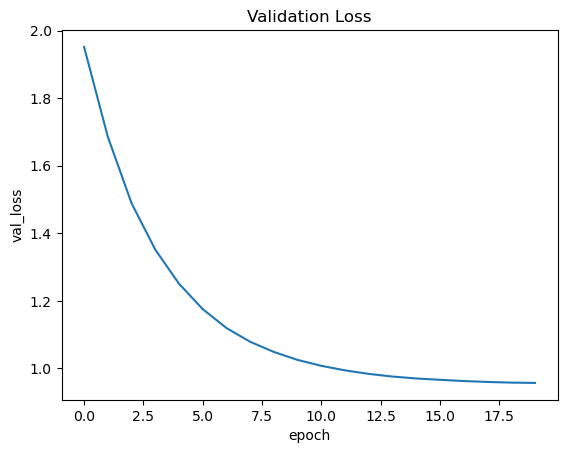

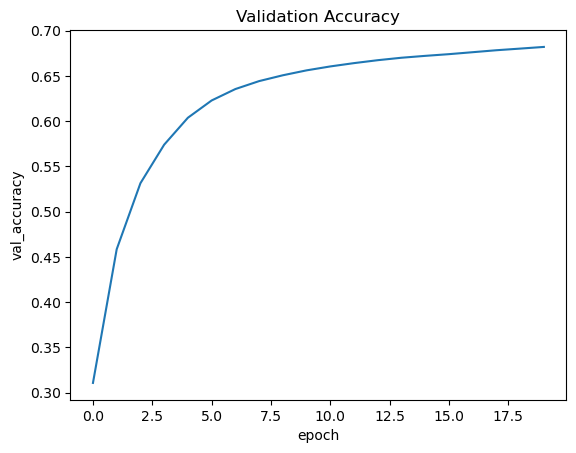

In [20]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [ ]:
######################## TEST ############################

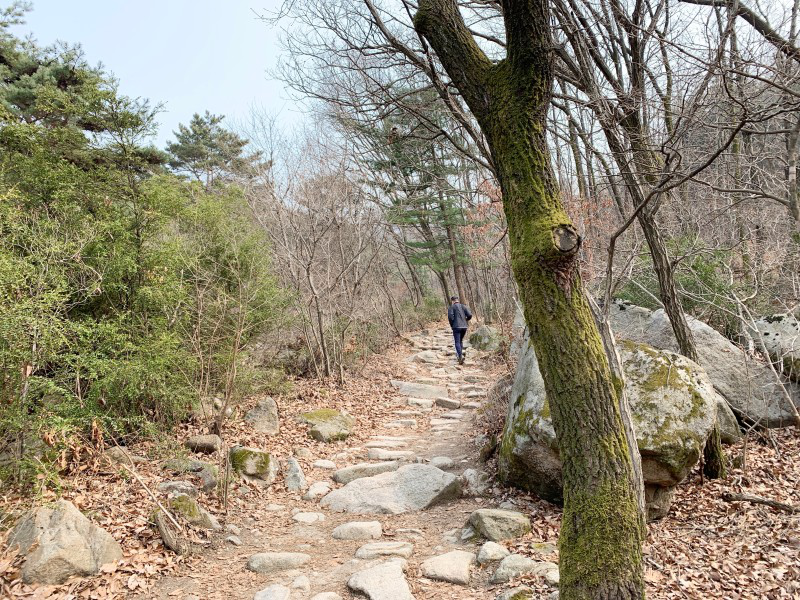

In [21]:
image_path = "./one.jpg"
Image.open(image_path)

In [22]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis = 0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.utils.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.utils.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, colormap, model):
    for image_file in images_list:
        print(image_file)
        image_tensor = read_image(image_file)
        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, 9)
        overlay = get_overlay(image_tensor, prediction_colormap)
        plot_samples_matplotlib(
            [image_tensor, overlay, prediction_colormap], figsize=(18, 14)
        )

./one.jpg
1/1 [==============================] - 1s 1s/step


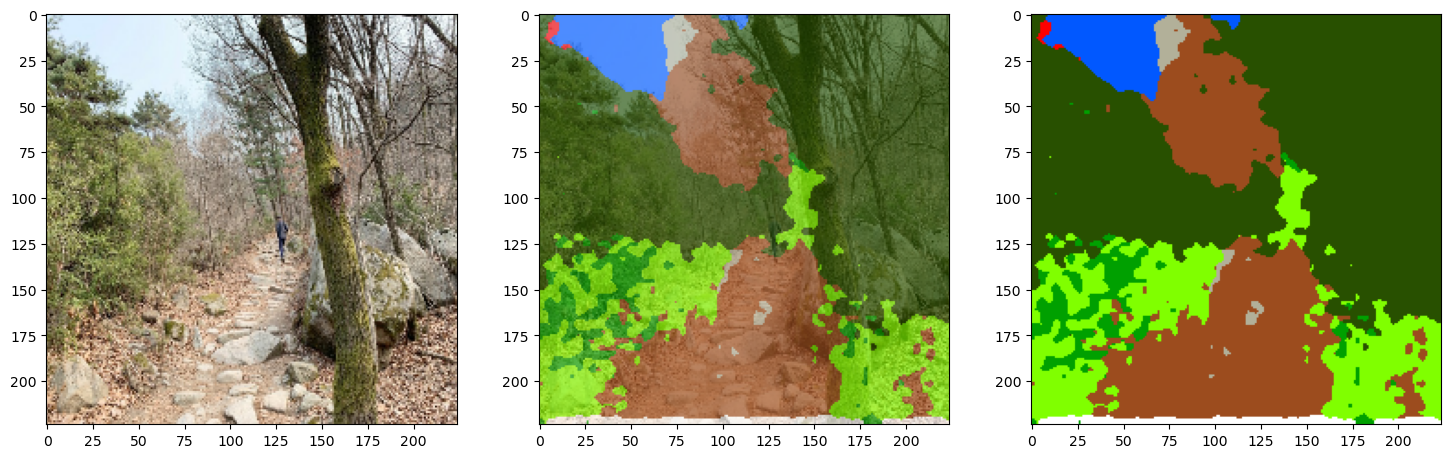

In [23]:
plot_predictions([image_path], palette, model=model)